In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pyfastaq.sequences import file_reader as fasta_reader
import swifter
import os

In [2]:
import sys
sys.path.insert(1, '..')
sys.path.insert(2, '../bindmate')

import bindmate

In [3]:
k = 30
input_file = "../../biodata_CTCF_TP53_l:300_n:10:10.fasta"
# input_file = "../../biodata_CTCF_TP53_l:300_n:200:200.fasta"

In [4]:
test_set = pd.DataFrame(
    [[entry.id, entry.seq] for entry in fasta_reader(input_file)],
    columns=['id', 'seq']
)
test_set["type"] = test_set["id"].str.split('-').str[0]
test_set['kmers'] = test_set['seq'].apply(lambda x: list(bindmate.make_kmers.get_overlapping_kmers(x, k)))

kmer_set = test_set.drop(columns=['seq', 'id']).explode("kmers").explode("kmers").drop_duplicates()
kmer_set = kmer_set.groupby(by='kmers').agg({
    "type": lambda x : ",".join(list(set(x)))
}).reset_index()
kmer_set.head()

,kmers,type
0,AAAAAGCCGGATTGGTAGATGCCTTTGGTG,CTCF
1,AAATAACCATAAAATTTTAAATAGAACAAT,CTCF
2,AAATGACCCCTAATATAGGAGCATATTGTT,CTCF
3,AAATGCTTCAGTAGTAGTGTTACCAGCAGA,CTCF
4,AACAGCGGGAAACGCCGTCTCCCCTGGCGT,TP53


In [5]:
kmer_set['kmers'].str.len().unique()

array([30])

In [6]:
# initialize functions
predefined_functions = bindmate.predefined_functions.initialize_available_functions(
    #    k, False, "random", 1000, dict()
     k, False, "sampled", 1000, dict(background_source_file='../bindmate/backgrounds/upstream2000.fa')
    )


Sampling background from ../bindmate/backgrounds/upstream2000.fa.


In [7]:
def calculate_metrics(metric, kmer_set, a='CTCF', b='TP53', only_metric=False):
    unique_kmers = kmer_set['kmers']
    metric.initialize(unique_kmers)
    
    kmer_combinations = bindmate.kmer_to_kmer_matchscores.__get_kmer_combinations(
        unique_kmers) 
    metric_values = bindmate.kmer_to_kmer_matchscores.__calculate_all_to_all_metric(
        kmer_combinations, unique_kmers, metric, -1)
    
    if only_metric:
        return metric_values
    
    metric_values = bindmate.kmer_to_kmer_matchscores.__translate_metric_to_rank(metric_values, metric.get_type(), -1)
    print(metric_values.shape)
    metric_values = metric_values + np.triu(metric_values + np.nan)

    # sns.heatmap(metric_values)
    # plt.show()

    metric_df = pd.DataFrame(metric_values).reset_index()
    metric_df = pd.melt(metric_df, id_vars='index')
    metric_df.columns = ['x', 'y', 'value']
    metric_df = pd.merge(metric_df, kmer_set[["type"]], left_on='x', right_index=True).rename(columns={"type":"type_x"})
    metric_df = pd.merge(metric_df, kmer_set[["type"]], left_on='y', right_index=True).rename(columns={"type":"type_y"})
    metric_df = metric_df[metric_df['x'] != metric_df['y']]
    metric_df['tmp'] = (metric_df['type_x'] == metric_df['type_y'])#.astype(str)
    metric_df = metric_df.dropna()

    metric_df['type'] = 'different'

    metric_df.loc[metric_df['tmp'] & (metric_df["type_x"] == a), 'type'] = a
    metric_df.loc[metric_df['tmp'] & (metric_df["type_x"] == b), 'type'] = b
    metric_df = metric_df[['x', 'y', 'value', 'type']]
    return metric_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:28<00:00,  5.85it/s]


(380, 380)


<Axes: xlabel='value', ylabel='Percent'>

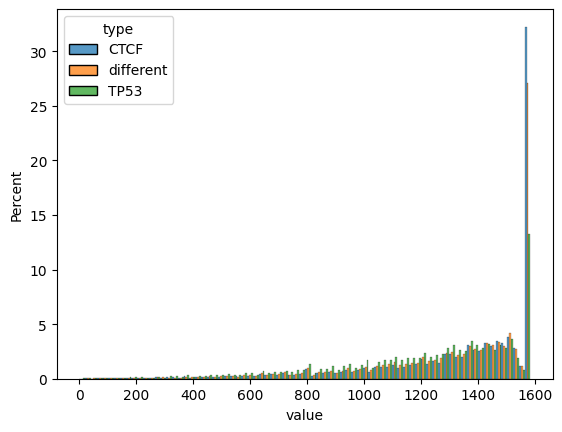

In [8]:
metric_df = calculate_metrics(predefined_functions['hoco_iou_human_basic_domains'], kmer_set)
sns.histplot(data=metric_df, x='value', hue='type', common_norm=False, stat='percent', multiple='dodge')

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


R[write to console]: Loading required package: S4Vectors

R[write to console]: 
Attaching package: ‘S4Vectors’


R[write to console]: The following objects are masked from ‘packag

Reading the input sequence......
Reading the input sequence......
Reading the input sequence......
Reading the input sequence......
Reading the input sequence......


R[write to console]: Parsing files......

R[write to console]: Read 760 items

R[write to console]: Record length: 30

R[write to console]: Read 760 items

R[write to console]: Record length: 29

R[write to console]: Read 760 items

R[write to console]: Record length: 30

R[write to console]: Read 760 items

R[write to console]: Record length: 29

R[write to console]: Read 760 items

R[write to console]: Record length: 30

R[write to console]: Done



(380, 380)


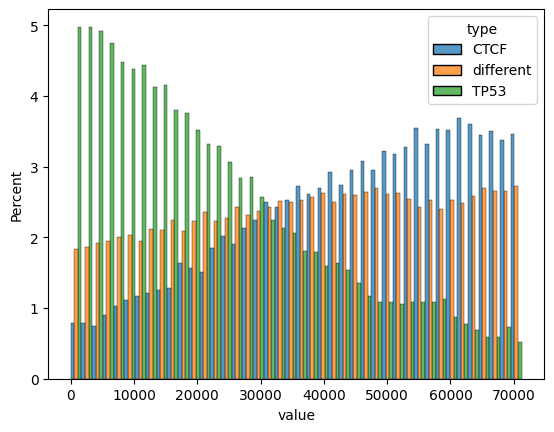

Reading the input sequence......
Reading the input sequence......
Reading the input sequence......
Reading the input sequence......
Reading the input sequence......


R[write to console]: Parsing files......

R[write to console]: Read 760 items

R[write to console]: Record length: 30

R[write to console]: Read 760 items

R[write to console]: Record length: 29

R[write to console]: Read 760 items

R[write to console]: Record length: 30

R[write to console]: Read 760 items

R[write to console]: Record length: 29

R[write to console]: Read 760 items

R[write to console]: Record length: 30

R[write to console]: Done



(380, 380)


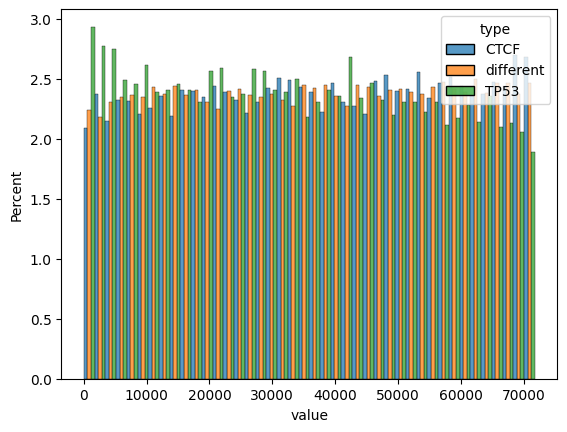

Reading the input sequence......
Reading the input sequence......
Reading the input sequence......
Reading the input sequence......
Reading the input sequence......


R[write to console]: Parsing files......

R[write to console]: Read 760 items

R[write to console]: Record length: 30

R[write to console]: Read 760 items

R[write to console]: Record length: 29

R[write to console]: Read 760 items

R[write to console]: Record length: 30

R[write to console]: Read 760 items

R[write to console]: Record length: 29

R[write to console]: Read 760 items

R[write to console]: Record length: 30

R[write to console]: Done



(380, 380)


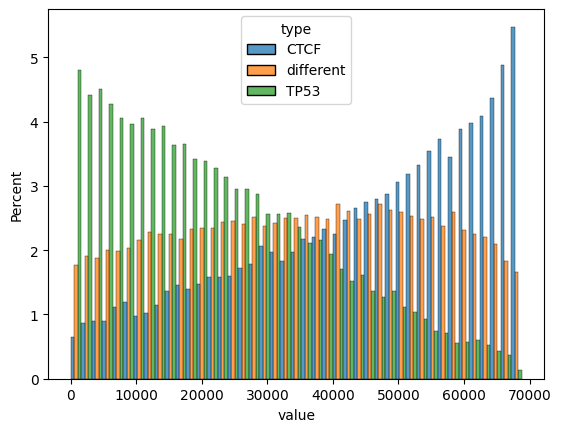

Reading the input sequence......
Reading the input sequence......
Reading the input sequence......
Reading the input sequence......
Reading the input sequence......


R[write to console]: Parsing files......

R[write to console]: Read 760 items

R[write to console]: Record length: 30

R[write to console]: Read 760 items

R[write to console]: Record length: 29

R[write to console]: Read 760 items

R[write to console]: Record length: 30

R[write to console]: Read 760 items

R[write to console]: Record length: 29

R[write to console]: Read 760 items

R[write to console]: Record length: 30

R[write to console]: Done



(380, 380)


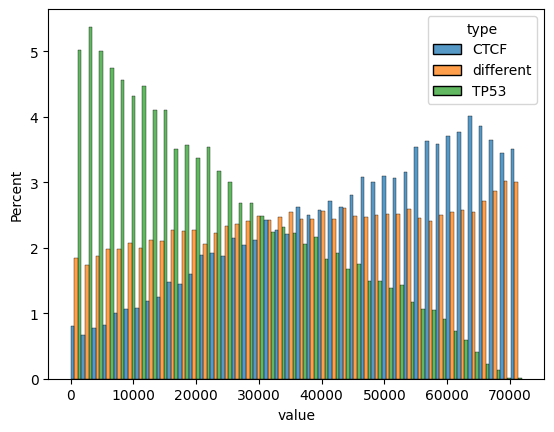

Reading the input sequence......
Reading the input sequence......
Reading the input sequence......
Reading the input sequence......
Reading the input sequence......


R[write to console]: Parsing files......

R[write to console]: Read 760 items

R[write to console]: Record length: 30

R[write to console]: Read 760 items

R[write to console]: Record length: 29

R[write to console]: Read 760 items

R[write to console]: Record length: 30

R[write to console]: Read 760 items

R[write to console]: Record length: 29

R[write to console]: Read 760 items

R[write to console]: Record length: 30

R[write to console]: Done



(380, 380)


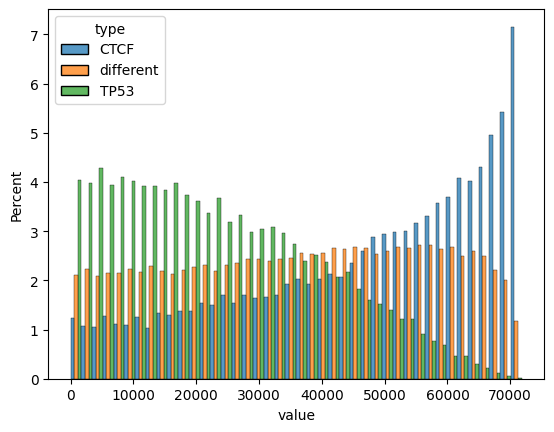

In [9]:
for item in ["EP", "HelT", "MGW", "ProT", "Roll"]:
    m = bindmate.predefined_functions.ShapeMetric(item)
    metric_df = calculate_metrics(m, kmer_set)

    sns.histplot(data=metric_df, x='value', hue='type', common_norm=False, stat='percent', multiple='dodge')
    plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:28<00:00,  5.83it/s]


(380, 380)


<Axes: xlabel='value', ylabel='Percent'>

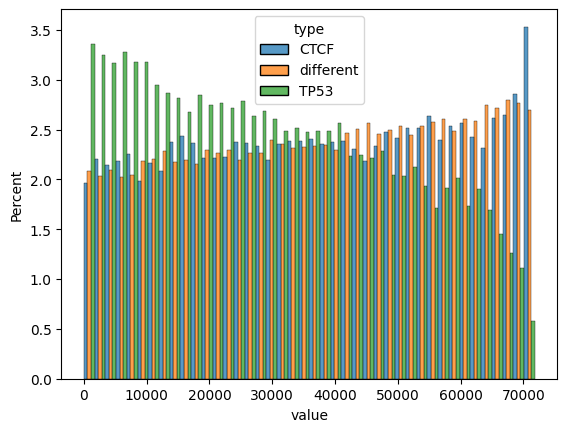

In [10]:
metric_df = calculate_metrics(predefined_functions['hoco_mse_human_basic_domains'], kmer_set, only_metric=False)
sns.histplot(data=metric_df, x='value', hue='type', common_norm=False, stat='percent', multiple='dodge')

In [11]:
to_try = [x for x in predefined_functions.keys() if x.startswith("hoco_mse_human") and not x.endswith("full")]

hoco_mse_human_c/ebp-related


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.15it/s]


(380, 380)


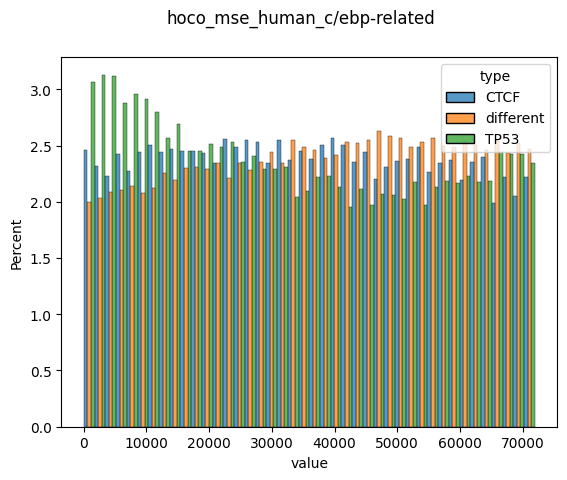

In [12]:
for item in to_try:
    print(item)
    m = predefined_functions[item]
    metric_df = calculate_metrics(m, kmer_set, only_metric=False)
    sns.histplot(data=metric_df, x='value', hue='type', common_norm=False, stat='percent', multiple='dodge')
    plt.suptitle(item)
    plt.show()
    break

(380, 380)


<Axes: xlabel='value', ylabel='Percent'>

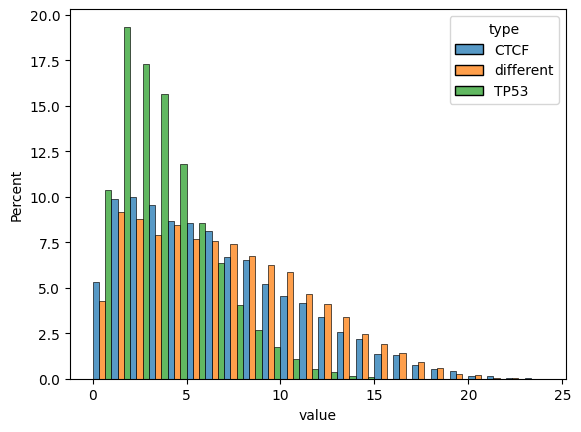

In [13]:
m = bindmate.predefined_functions.GCcontent()
metric_df = calculate_metrics(m, kmer_set, only_metric=False)
sns.histplot(data=metric_df, x='value', hue='type', binwidth=1,
             common_norm=False, stat='percent', multiple='dodge')

(380, 380)


<Axes: xlabel='value', ylabel='Percent'>

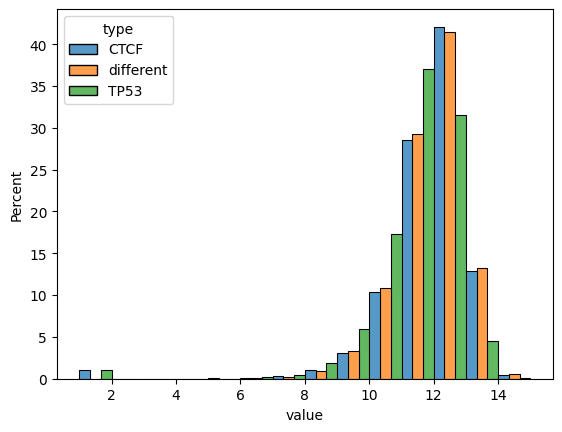

In [14]:
m = bindmate.predefined_functions.LCSmetric()
metric_df = calculate_metrics(m, kmer_set, only_metric=False)
sns.histplot(data=metric_df, x='value', hue='type', binwidth=1,
             common_norm=False, stat='percent', multiple='dodge')